In [1]:
import os
import pandas as pd
import google.generativeai as genai
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import time

# Load API Key from .env file
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# Configure Gemini
try:
    genai.configure(api_key=GEMINI_API_KEY)
    llm = genai.GenerativeModel('gemini-2.5-flash')
    print("✅ Gemini model configured successfully.")
except Exception as e:
    llm = None
    print(f"Error configuring Gemini model: {e}")

c:\Users\hemva\Documents\Programs\FinSight\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Gemini model configured successfully.


In [2]:
def get_gemini_sentiment(headline: str) -> str:
    """Sends a single headline to Gemini for sentiment analysis."""
    if not llm:
        return "Neutral" # Default on error

    prompt = f"""
    Analyze the sentiment of the following financial news headline from an investor's perspective.
    - Use "Bullish" for news that clearly suggests positive future performance or outperforms expectations.
    - Use "Bearish" for news that clearly suggests negative future performance or underperforms expectations.
    - Use "Neutral" for factual statements, announcements, or news that does not have a clear positive or negative implication.

    Respond with a single word: Bullish, Bearish, or Neutral. Do not add any other text.

    Headline: "{headline}"
    """
    
    try:
        response = llm.generate_content(prompt)
        # Add a small delay to avoid hitting API rate limits
        time.sleep(7) 
        sentiment = response.text.strip().capitalize()
        if sentiment in ["Bullish", "Bearish", "Neutral"]:
            return sentiment
        return "Neutral" # Default if response is malformed
    except Exception as e:
        print(f"API call failed for headline: {headline}. Error: {e}")
        return "Neutral"

In [33]:
# Load the dataset
df = pd.read_csv("all-data.csv", encoding='latin-1', names=['Sentiment', 'News Headline'])
# Map dataset labels to our labels
label_map = {'positive': 'Bullish', 'negative': 'Bearish', 'neutral': 'Neutral'}
df.columns = df.columns.str.lower()

df['actual_label'] = df['sentiment'].map(label_map)

print(df.head())

  sentiment                                      news headline actual_label
0   neutral  According to Gran , the company has no plans t...      Neutral
1   neutral  Technopolis plans to develop in stages an area...      Neutral
2  negative  The international electronic industry company ...      Bearish
3  positive  With the new production plant the company woul...      Bullish
4  positive  According to the company 's updated strategy f...      Bullish


In [ ]:
# --- Create a Balanced Sample ---
# We will take an equal number of samples from each sentiment category.
# Let's take 50 from each, for a total of 150 samples.
n_samples_per_class = 50

# Group by the actual label and take a random sample from each group
balanced_sample_df = df.groupby('actual_label', group_keys=False).apply(lambda x: x.sample(n_samples_per_class, random_state=42))

actual_labels = []
predicted_labels = []

print(f"Evaluating Gemini sentiment on a balanced sample of {len(balanced_sample_df)} headlines...")

# Using tqdm for a nice progress bar in the notebook
for index, row in tqdm(balanced_sample_df.iterrows(), total=balanced_sample_df.shape[0]):
    actual_labels.append(row['actual_label'])
    predicted_sentiment = get_gemini_sentiment(row['news headline'])
    predicted_labels.append(predicted_sentiment)
    
print("\n✅ Evaluation complete.")

--- Gemini Sentiment Analysis Evaluation Report ---
              precision    recall  f1-score   support

     Bearish       0.98      0.82      0.89        50
     Bullish       0.87      0.66      0.75        50
     Neutral       0.69      0.96      0.80        50

    accuracy                           0.81       150
   macro avg       0.84      0.81      0.81       150
weighted avg       0.84      0.81      0.81       150



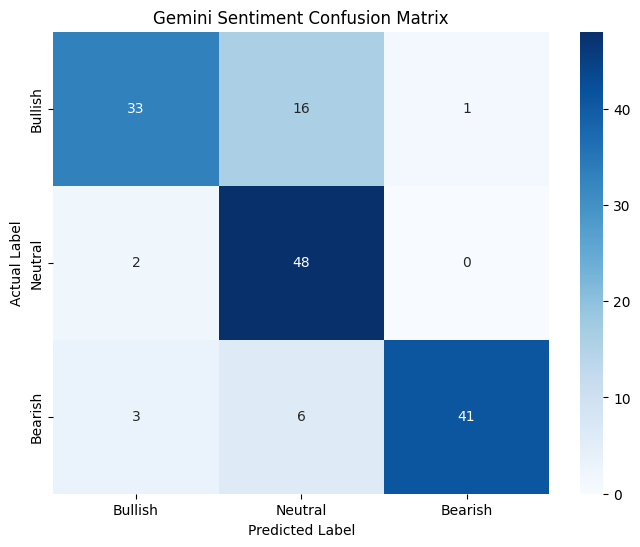

In [35]:
# --- Generate and Print the Report ---
print("--- Gemini Sentiment Analysis Evaluation Report ---")
print(classification_report(actual_labels, predicted_labels))

# --- Generate and Display the Confusion Matrix ---
cm = confusion_matrix(actual_labels, predicted_labels, labels=["Bullish", "Neutral", "Bearish"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Bullish", "Neutral", "Bearish"], 
            yticklabels=["Bullish", "Neutral", "Bearish"])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Gemini Sentiment Confusion Matrix')
plt.show()

--- Gemini Sentiment Analysis Evaluation Report ---
              precision    recall  f1-score   support

     Bearish       0.89      0.98      0.93        50
     Bullish       0.66      0.94      0.78        50
     Neutral       0.88      0.42      0.57        50

    accuracy                           0.78       150
   macro avg       0.81      0.78      0.76       150
weighted avg       0.81      0.78      0.76       150



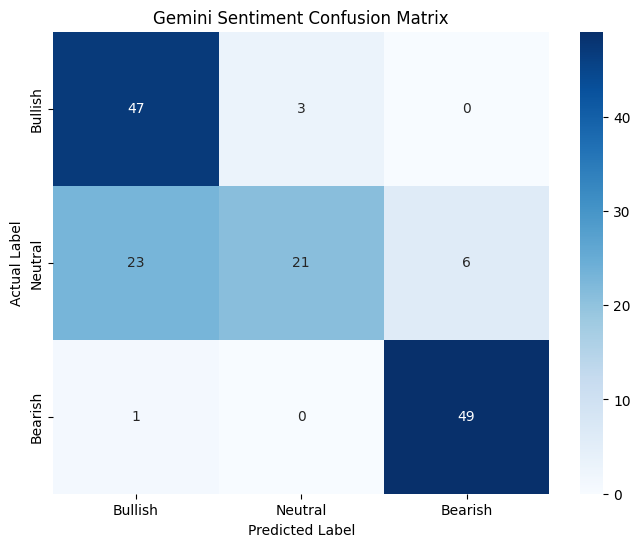

In [31]:
# --- Generate and Print the Report ---
print("--- Gemini Sentiment Analysis Evaluation Report ---")
print(classification_report(actual_labels, predicted_labels))

# --- Generate and Display the Confusion Matrix ---
cm = confusion_matrix(actual_labels, predicted_labels, labels=["Bullish", "Neutral", "Bearish"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Bullish", "Neutral", "Bearish"], 
            yticklabels=["Bullish", "Neutral", "Bearish"])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Gemini Sentiment Confusion Matrix')
plt.show()